In [ ]:
# !pip install shap

In [1]:
# Import libraries
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random
import lime
from lime import lime_tabular
import shap

import json
from typing import Union
from datetime import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np


In [2]:
root = "/storage/scratch/e17-4yp-xai/Documents/artefact_backup/backup_1M_inputs_rand_frst/model_outputs/artifacts/random_forest"

In [3]:
train_files = sorted(['train_fold_1_2017-01-06.csv', 'train_fold_2_2016-09-08.csv', 'train_fold_3_2016-05-11.csv', 'train_fold_4_2016-01-12.csv', 'train_fold_5_2015-09-14.csv' , 'train_fold_6_2015-05-17.csv'], reverse=True)
test_files = [ 'test_fold_6_2015-05-17.csv' , 'test_fold_5_2015-09-14.csv', 'test_fold_4_2016-01-12.csv', 'test_fold_3_2016-05-11.csv',  'test_fold_2_2016-09-08.csv', 'test_fold_1_2017-01-06.csv']


test_pred = ['test_prediction_fold_6_2015-05-17.csv' , 'test_prediction_fold_5_2015-09-14.csv', 'test_prediction_fold_4_2016-01-12.csv', 'test_prediction_fold_3_2016-05-11.csv', 'test_prediction_fold_2_2016-09-08.csv' , 'test_prediction_fold_1_2017-01-06.csv' ]

models = sorted(["random_forest_fold_1_2017-01-06.pkl", "random_forest_fold_2_2016-09-08.pkl", "random_forest_fold_3_2016-05-11.pkl", "random_forest_fold_4_2016-01-12.pkl", "random_forest_fold_5_2015-09-14.pkl", "random_forest_fold_6_2015-05-17.pkl" ], reverse = True)

In [4]:

# ROOT = "/storage/scratch/e17-4yp-xai/Documents/e17-4yp-using-machine-learning-in-high-stake-settings/code/"
ROOT = "./"
DATA_SOURCE = ROOT + "data/DsDnsPrScTch.csv"
DATA_DEST = ROOT + "processed_data/"
MODEL_DEST = ROOT + "trained_models/"
IMAGE_DEST = ROOT + "model_outputs/figures/"
LIME_DEST = ROOT + "model_outputs/lime/"
SHAP_DEST = ROOT + "model_outputs/shap/"
TREESHAP_DEST = ROOT + "model_outputs/treeshap/"
K_PROJECTS_DEST = IMAGE_DEST + "k_projects/"
ROC_CURVE_DEST = IMAGE_DEST + "roc_curve/"
P_VS_R_CURVE_DEST = IMAGE_DEST + "pr_curve/"
ARTIFACTS_PATH = ROOT + "model_outputs/artifacts/"

INFO_DEST = ROOT+"model_outputs/info/"
# MODEL_RUN_LOG_PATH = INFO_DEST + "model_run_log.py"
PROCESSED_DATA_PATH = DATA_DEST + "labelled_final_data.csv"

LOAD_PROCESSED_DATA_FLAG = False
MAX_ROWS = 400000  # if you change this, updating LOAD_PROCESSED_DATA_FLAG to False is required

FIXED_KVAL = 1000

# To label data
DONATION_PERIOD = 30
THRESHOLD_RATIO = 0.4

TRAINING_WINDOW = DONATION_PERIOD * 4

MAX_TIME = "2016-04-01 00:00:00"
MIN_TIME = "2013-05-01 00:00:00"

TEST_SIZE = 30
TRAIN_SIZE = TEST_SIZE*6
LEAK_OFFSET = TEST_SIZE*4
WINDOW = TEST_SIZE + TRAIN_SIZE + 2*LEAK_OFFSET


DATE_COLS = ["Teacher First Project Posted Date", "Project Fully Funded Date", "Project Expiration Date",
             "Project Posted Date", "Donation Received Date"]
CATEGORICAL_COLS = ["Project Type", "Project Subject Category Tree", "Project Subject Subcategory Tree",
                    "Project Grade Level Category", "Project Resource Category", "School Metro Type",
                    "School State", "School County", "Teacher Prefix", "School Name", "School City", "School District"]

TRAINING_FEATURES = ["Project ID", "Project Posted Date", "Project Type", "Project Subject Category Tree", "Project Cost",
                     "Project Subject Subcategory Tree", "Project Grade Level Category", "Project Resource Category",
                     "School Metro Type", "School Percentage Free Lunch", "School State", "School County",
                     "School Name", "School City", "School District",
                     "Teacher Prefix", "Teacher Project Posted Sequence"]
#   "Statement Error Ratio", "Title Essay Relativity", "Description Essay Relativity"]

VARIABLES_TO_SCALE = ["School Percentage Free Lunch", "Teacher Project Posted Sequence", "Project Cost",
                      'Teacher Success Rate', 'School City Success Rate', 'School Success Rate',
                      'School County Success Rate', 'Project Count in State']
# "Statement Error Ratio", "Title Essay Relativity", "Description Essay Relativity"]


In [5]:


def save_model(path, file_name, model):
    file_path = path + file_name
    pickle.dump(model, file=open(file_path, "wb"))


def load_model(model_file_path):
    return pickle.load(open(model_file_path, 'rb'))

def log_intermediate_output_to_file(path, file_name, log_info: Union[list, dict, str]):
    file_path = path + file_name
    json_data = json.dumps(log_info, indent=2)
    time = dt.now()
    with open(file_path, 'a') as file:
        file.write(f"\nlog {str(time.strftime('%Y-%m-%d %H:%M:%S'))}\n{json_data}\n")


def create_dirs(models=None):
    if not models:
        models = ['decision_tree', 'log_reg', 'random_forest', 'svm']
    paths = [
        config.ARTIFACTS_PATH+model_dir+'/' for model_dir in models
    ] + [
        config.IMAGE_DEST+model_dir+'/' for model_dir in models
    ] + [
        config.IMAGE_DEST+'k_projects/'+model_dir+'/' for model_dir in models
    ] + [
        config.INFO_DEST+model_dir+'/' for model_dir in models
    ] + [
        config.ROOT+'trained_models/', config.ROOT+'processed_data/'
    ]
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

    print(f"{len(paths)} directories created...")
    print('Created all directories!')


def create_random_forest_parameters(
    max_depths=[2, 3],
    n_estimators=[20, 100],
    min_samples_split=2,
    min_samples_leaf=2,
) -> list:
    parameters_list = []
    # create various combinations of the above attributes
    for max_depth in max_depths:
        for n in n_estimators:
            parameters = {
                'criterion': "gini",
                'max_depth': max_depth,
                'n_estimators': n,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf
            }
            parameters_list.append(parameters)
    return parameters_list


def create_logistic_regression_parameters(
        solver="saga",
        max_iters=[100, 200],
        penalties=["l1", "l2"]
) -> list:
    parameters_list = []
    for penalty in penalties:
        for max_iter in max_iters:
            parameters = {
                'penalty': penalty,
                'solver': solver,
                'max_iter': max_iter
            }
            parameters_list.append(parameters)

    return parameters_list


def create_classification_models(
        random_forest_parameters_list: list,
        logistic_regression_parameters_list: list
) -> list:
    models_list = []
    i = 1
    for parameters in random_forest_parameters_list:
        new_model = RandomForestClassifier(**parameters)
        models_list.append({
            'model_name': f'random_forest_{i}',
            'model': new_model,
            'type': 'non-linear',
            'parameters': parameters
        })
        i += 1

    i = 1
    for parameters in logistic_regression_parameters_list:
        new_model = LogisticRegression(**parameters)
        models_list.append({
            'model_name': f'logistic_regression_{i}',
            'model': new_model,
            'type': 'linear',
            'parameters': parameters
        })
        i += 1
    cost_sorted_k_baseline_model = {
        'model_name': 'cost_sorted_k_baseline_model',
        'model': None,
        'type': 'baseline'
    }
    random_k_baseline_model = {
        'model_name': 'random_k_baseline_model',
        'model': None,
        'type': 'baseline'
    }
    models_list.append(cost_sorted_k_baseline_model)
    models_list.append(random_k_baseline_model)

    return models_list


In [6]:


def save_lime_explanation(exp, instance_loc, model_name, position, project_id,fold):

    # exp.show_in_notebook(show_table=True)
    # Save as html file
    filepath = f"{LIME_DEST}{fold}/{position}"
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
    
    exp.save_to_file(f'{LIME_DEST}{fold}/{position}/lime_exp_{project_id}_{model_name}.html')

    # Save as pyplot figure
#     plt.cla()
    exp.as_pyplot_figure()
    plt.savefig(f'{LIME_DEST}{fold}/{position}/lime_exp_{project_id}_{model_name}.png')
    plt.show()
    plt.cla()

    return

def get_lime_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, class_names, mode, model, model_name, fold):

    # take the list of instances and save the explaination of each instance.
    # LIME: define the explainer
    # Ex: mode = 'classification' or 'regression'
    #     class_names = ['0', '1']

    categorical_feature_names = x_train.dtypes[x_train.dtypes==bool].index.to_list()
    categorical_feature_index = [x_train.columns.get_loc(col) for col in categorical_feature_names]
    
    
    explainer_lime = lime_tabular.LimeTabularExplainer(
        training_data=np.array(x_train),
        feature_names=x_train.columns,
        categorical_features = categorical_feature_index,
        class_names=class_names,
        mode=mode
    )
    
    
    for instance_loc in top_instance_loc_list:
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        # Get the explanation
        exp1 = explainer_lime.explain_instance(
            data_row=instance,
            predict_fn=model.predict_proba
        )
        # Save the explanation as a figure
        save_lime_explanation(exp1, instance_loc, model_name, "top", project_id, fold)
        
    for instance_loc in bottom_instance_loc_list:
        # Select instance 
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        # Get the explanation
        exp2 = explainer_lime.explain_instance(
            data_row=instance,
            predict_fn=model.predict_proba
        )
        # Save the explanation as a figure
        save_lime_explanation(exp2, instance_loc, model_name, "bottom", project_id, fold)






In [7]:


def get_shap_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, model, model_name, fold):
    
    

    # Define the KernelSHAP explainer
    print("Kernel Explainer Loading ..... ")
    explainer_shap = shap.KernelExplainer(model=model.predict_proba, data=x_train)
    filepath = f'{SHAP_DEST}{fold}/top/'
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
        
    filepath = f'{SHAP_DEST}{fold}/bottom/'
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
            
            
    print("Top list")    
    
    for i, instance_loc in enumerate(top_instance_loc_list):
        print(f"{i} th  of the instance explanation")
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        
        # Find the explanation
        shap_values = explainer_shap.shap_values(instance)

        # Visualize and save
        # Can be either 0 or 1 for binary classification
        #shap.force_plot(explainer_shap.expected_value[0], shap_values[0], instance)
        filepath = f'{SHAP_DEST}{fold}/top/shap_exp_{project_id}_{model_name}.png'
        
        print(f"Explanation plot for instance {i}")
        shap.force_plot(explainer_shap.expected_value[1], 
                        shap_values[1], 
                        instance, 
                        show=False, 
                        matplotlib=True, 
                        text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight') 
        
        
#                         text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight') 
        
    print("Bottom list")
    for i, instance_loc in enumerate(bottom_instance_loc_list):
        print(f"{i} th  of the instance explanation")
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        # Find the explanation
        shap_values = explainer_shap.shap_values(instance)

        # Visualize and save
        # Can be either 0 or 1 for binary classification
        #shap.force_plot(explainer_shap.expected_value[0], shap_values[0], instance)
        filepath = f'{SHAP_DEST}{fold}/bottom/shap_exp_{project_id}_{model_name}.png'
        
            
        print(f"Explanation plot for instance {i}")
        shap.force_plot(explainer_shap.expected_value[1], 
                        shap_values[1], 
                        instance, 
                        show=False, 
                        matplotlib=True, 
                        text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight') 
        

    

In [8]:

def get_treeshap_explanation(x_train, x_test, top_instance_loc_list, bottom_instance_loc_list, model, model_name, fold):
    
#     print(x_train.head())
    # Define the KernelSHAP explainer
#     explainer_tree = shap.TreeExplainer(model=model, data=x_train, model_output="raw")
    explainer_tree = shap.TreeExplainer(model=model, feature_perturbation='tree_path_dependant')
    
    filepath = f'{TREESHAP_DEST}{fold}/top/'
    
    
    
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
        
    filepath = f'{TREESHAP_DEST}{fold}/bottom/'
    
    try:
        os.makedirs(filepath, exist_ok = True)
        print("Directory '%s' created successfully" %filepath)
    except OSError as error:
        print("Directory '%s' can not be created")
            
    print("Top list")    
            
    for i, instance_loc in enumerate(top_instance_loc_list):
        print(f"{i} th  of the instance explanation")
        # Select instance
        instance = x_test.iloc[[instance_loc]]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"], axis=1)
        # Find the explanation
        treeshap_values = explainer_tree.shap_values(instance)

        print(f"Explanation plot for instance {i}")
        # Visualize and save
        filepath = f'{TREESHAP_DEST}{fold}/top/treeshap_exp_{project_id}_{model_name}.png'
        shap.force_plot(explainer_tree.expected_value[1], 
                    treeshap_values[1],
                    instance,
                    show=False, 
                    matplotlib=True, 
                    text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight')
        
    
    print("Bottom list")
    for i, instance_loc in enumerate(bottom_instance_loc_list):
        print(f"{i} th  of the instance explanation")
        # Select instance
        instance = x_test.iloc[instance_loc]
        # Find its Project ID
        project_id = instance["Project ID"]
        # Drop the Project ID value from the instance since its not a feature
        instance = instance.drop(["Project ID"])
        # Find the explanation
        treeshap_values = explainer_tree.shap_values(instance)

        # Visualize and save
        filepath = f'{TREESHAP_DEST}{fold}/bottom/treeshap_exp_{project_id}_{model_name}.png'
        
         
        print(f"Explanation plot for instance {i}")
        shap.force_plot(explainer_tree.expected_value[1], 
                    treeshap_values[1],
                    instance,
                    show=False, 
                    matplotlib=True, 
                    text_rotation=45).savefig(filepath, format = "png", dpi = 150, bbox_inches = 'tight')
        
        

In [9]:
import pandas as pd
import os
import pickle
import random
# New pipeline for ruinning the explainations - call this from main
def explanations_pipeline(root, model_paths, train_paths, test_paths, pred_paths, model_name):
  """this pipeline will generate explanations for the given model paths

  Args:
      root (_type_): This is the root path of the model artifacts
      model_paths (_type_): these are the paths to the model artifacts
      train_paths (_type_): these are the paths to the train artifacts
      test_paths (_type_): these are the paths to the test artifacts
      pred_paths (_type_): these are the paths to the prediction artifacts
      model_name (str): this is the model name as a string for identification. ex: "random forest"
      
      all the artifacts should be a list of files and should be in the same order
  """
  assert len(train_paths) == len(test_paths), "There should be same number of train paths and test paths"
  assert len(test_paths) == len(pred_paths), "There should be same number of predictions paths and test paths"
  assert len(model_paths) == len(test_paths), "There should be same number of model_paths paths and test paths"
  
  for i in range(len(train_paths)):
    print(f"Fold {i} .............................")
    x_train = pd.read_csv(os.path.join(root, train_paths[i]))
    x_train_cleaned = x_train.drop(["Unnamed: 0", "Project ID", "Label"], axis=1)

    fold1 = pd.read_csv(os.path.join(root,test_paths[i]))
    fold_pred =  pd.read_csv(os.path.join(root,  pred_paths[i]))
    Fold1 = pd.concat([fold1, fold_pred["1"]],axis=1)
    Fold1 = Fold1.drop(["Unnamed: 0"],axis=1)
    Fold1_sort = Fold1.sort_values(["1"], ascending=False)
    #Fold1_sort.head()
    x_test_with_id = Fold1_sort.drop([ "Label", "1"],axis=1)

    # Select 50 samples each from top and bottom 1000 records
    print("Sampling the top 50 and bottom 50")
    top_instance_loc_list = random.sample(range(1000), 50)
    bottom_instance_loc_list = random.sample(range(x_test_with_id.shape[0]-1000 , x_test_with_id.shape[0]), 50)
    # Get the project IDs of those selected records
    #top_project_ids = [x_test_with_id._get_value(i, "Project ID") for i in top_instance_loc_list]
    #bottom_project_ids = [x_test_with_id._get_value(i, "Project ID") for i in bottom_instance_loc_list]

    # Drop the project ID column
    #x_test = x_test_with_id.drop(["Project ID"], axis=1)

    print(f"Model {model_paths} is loading" )

    # Load the saved model
    model = load_model(os.path.join(root, model_paths[i]))

    print(f"Explanation for  Lime" )
    # Get explanations
    get_lime_explanation(x_train_cleaned[:100].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, ["0", "1"], "classification", model, model_name,f"Fold{i}")
    print(f"Explanation for  Kernal Shap" )
    get_shap_explanation(x_train_cleaned[:100].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, model, model_name, f"Fold{i}") 
    print(f"Explanation for  Tree Shap" )
    get_treeshap_explanation(x_train_cleaned[:100].astype("float64"), x_test_with_id, top_instance_loc_list, bottom_instance_loc_list, model, model_name,f"Fold{i}") 
    print(f"Explanation for  Tree Shap" )
  
  return

In [10]:
# explanations_pipeline(root, models, train_files, test_files, test_pred, "random_forest")

Fold 0 .............................
Sampling the top 50 and bottom 50
Model ['random_forest_fold_6_2015-05-17.pkl', 'random_forest_fold_5_2015-09-14.pkl', 'random_forest_fold_4_2016-01-12.pkl', 'random_forest_fold_3_2016-05-11.pkl', 'random_forest_fold_2_2016-09-08.pkl', 'random_forest_fold_1_2017-01-06.pkl'] is loading


Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


Explanation for  Lime
Kernel Explainer Loading ..... 
Directory './model_outputs/shap/0/top/' created successfully
Directory './model_outputs/shap/0/bottom/' created successfully
Top list
0 th  of the instance explanation
Explanation plot for instance 0
1 th  of the instance explanation
Explanation plot for instance 1
2 th  of the instance explanation
Explanation plot for instance 2
3 th  of the instance explanation


KeyboardInterrupt: 

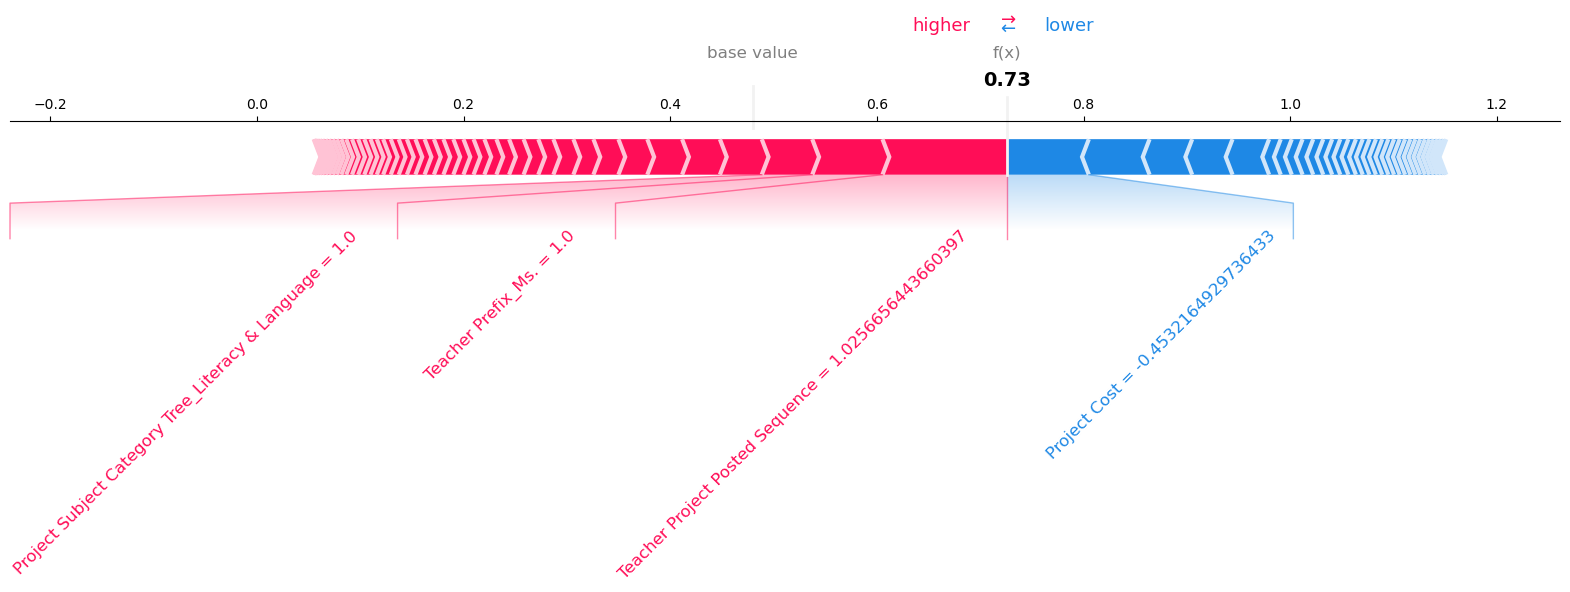

Error in callback <function flush_figures at 0x7f2ba7a72dd0> (for post_execute):


KeyboardInterrupt: 

In [11]:
explanations_pipeline(root, models, train_files, test_files, test_pred, "random_forest")